# **Structure from Motion (SfM)**

This project implements an incremental **Structure from Motion (SfM)** pipeline to reconstruct a **sparse 3D point cloud** from a monocular image sequence using classical multi-view geometry techniques.

The implementation follows an **incremental SfM approach**, where camera poses and 3D points are estimated progressively as new images are added.

---

## **Pipeline Overview**

The SfM pipeline consists of the following stages:

1. Camera intrinsic loading
2. Image loading and downscaling
3. Feature detection and matching
4. Two-view geometry (Essential matrix estimation)
5. Initial camera pose recovery
6. Triangulation of initial 3D points
7. Incremental camera pose estimation using PnP
8. Incremental triangulation of new points
9. Reprojection error validation
10. Sparse point cloud export (`.ply` format)

---

## **Dataset**

- Monocular image sequence (Gustav II Adolf dataset)  
- Images captured with sufficient overlap for multi-view geometry  
- Camera intrinsic parameters provided in `K.txt`

---

## **Output**

- Colored sparse 3D point cloud, viewable in **MeshLab** or **CloudCompare**



### **Environment Setup**

In [52]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tomlkit
!pip uninstall opencv-python opencv-python-headless -y
!pip install opencv-python


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (67.0 MB)


### **Import necessary libraries**

In [1]:
import cv2
import numpy as np
import os
from scipy.optimize import least_squares
from tomlkit import boolean
from tqdm import tqdm
import matplotlib.pyplot as plt


## **Camera Intrinsics and Image Loading**

This step loads:
- Camera intrinsic matrix **K**
- Image sequence
- Applies downscaling consistently to images and intrinsics

In [2]:
class Image_loader():
    def __init__(self, img_dir:str, downscale_factor:float):
        # loading the Camera intrinsic parameters K
        with open(img_dir + '/K.txt') as f:
            self.K = np.array(list((map(lambda x:list(map(lambda x:float(x), x.strip().split(' '))),f.read().split('\n')))))
            self.image_list = []
        # Loading the set of images
        for image in sorted(os.listdir(img_dir)):
            if image[-4:].lower() == '.jpg' or image[-5:].lower() == '.png':
                self.image_list.append(img_dir + '/' + image)

        self.path = os.getcwd()
        self.factor = downscale_factor
        self.downscale()


    def downscale(self) -> None:
        '''
        Downscales the Image intrinsic parameter acc to the downscale factor
        '''
        self.K[0, 0] /= self.factor
        self.K[1, 1] /= self.factor
        self.K[0, 2] /= self.factor
        self.K[1, 2] /= self.factor

    def downscale_image(self, image):
        for _ in range(1,int(self.factor / 2) + 1):
            image = cv2.pyrDown(image)
        return image


img_obj = Image_loader("/content/drive/MyDrive/Datasets/GustavIIAdolf", downscale_factor=2.0)


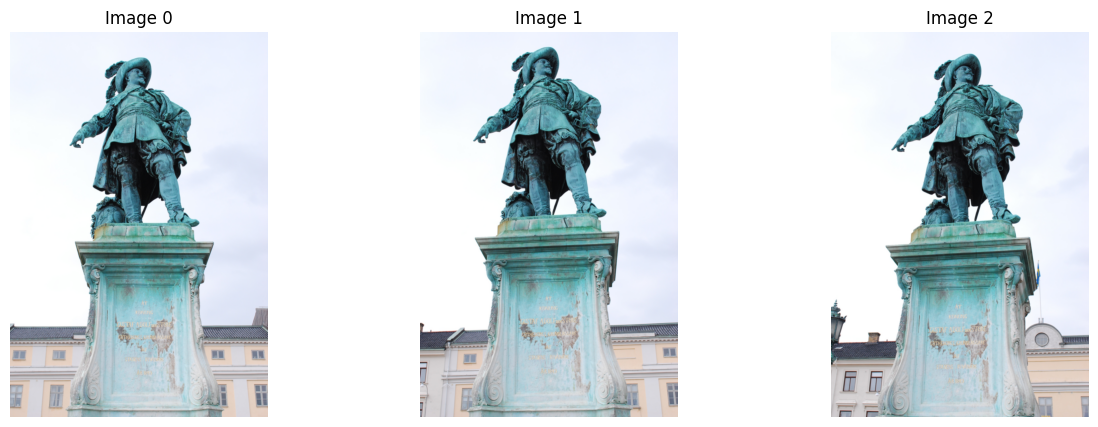

In [3]:
# Show first 3 images from the dataset
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    img = img_obj.downscale_image(cv2.imread(img_obj.image_list[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i}")
    axs[i].axis("off")

plt.show()


## **Feature Detection using SIFT**

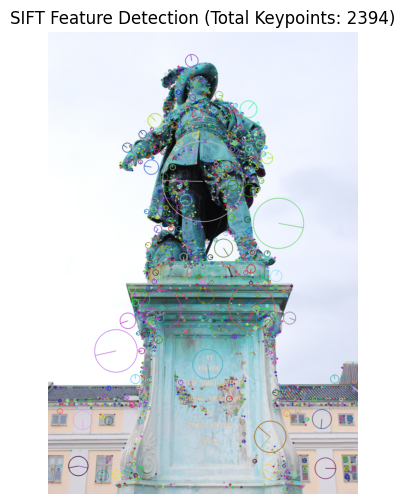

In [10]:
example_img = img_obj.downscale_image(cv2.imread(img_obj.image_list[0]))
gray_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray_img, None)

# Draw keypoints on the image
img_with_kp = cv2.drawKeypoints(example_img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show the image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.title(f"SIFT Feature Detection (Total Keypoints: {len(keypoints)})")
plt.axis("off")
plt.show()


## **Geometric Functions**

These functions handle:
- **Triangulation:** Computes 3D points from matched 2D features in two views using camera projection matrices.
- **PnP pose estimation:** Estimates camera rotation and translation from 3D–2D correspondences using a RANSAC-based solver.
- **Reprojection error computation:** Measures reconstruction accuracy by comparing observed 2D points with projected 3D points.
- **Bundle-adjustment cost function:** Defines the reprojection error used to jointly refine camera poses and 3D points.

In [4]:

def triangulation(point_2d_1, point_2d_2, projection_matrix_1, projection_matrix_2) -> tuple:
    '''
    Triangulates 3d points from 2d vectors and projection matrices
    returns projection matrix of first camera, projection matrix of second camera, point cloud
    '''
    pt_cloud = cv2.triangulatePoints(point_2d_1, point_2d_2, projection_matrix_1.T, projection_matrix_2.T)
    return projection_matrix_1.T, projection_matrix_2.T, (pt_cloud / pt_cloud[3])

def PnP(obj_point, image_point, K, dist_coeff, rot_vector, initial) -> tuple:
    '''
    Finds an object pose from 3D-2D point correspondences using the RANSAC scheme.
    returns rotational matrix, translational matrix, image points, object points, rotational vector
    '''
    if initial == 1:
        obj_point = obj_point[:, 0, :]
        image_point = image_point.T
        rot_vector = rot_vector.T
    _, rot_vector_calc, tran_vector, inlier = cv2.solvePnPRansac(obj_point, image_point, K, dist_coeff, cv2.SOLVEPNP_ITERATIVE)
    # Converts a rotation matrix to a rotation vector or vice versa
    rot_matrix, _ = cv2.Rodrigues(rot_vector_calc)

    if inlier is not None:
        image_point = image_point[inlier[:, 0]]
        obj_point = obj_point[inlier[:, 0]]
        rot_vector = rot_vector[inlier[:, 0]]
    return rot_matrix, tran_vector, image_point, obj_point, rot_vector

def reprojection_error(obj_points, image_points, transform_matrix, K, homogenity) -> tuple:
    '''
    Calculates the reprojection error ie the distance between the projected points and the actual points.
    returns total error, object points
    '''
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    if homogenity == 1:
        obj_points = cv2.convertPointsFromHomogeneous(obj_points.T)
    image_points_calc, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points_calc = np.float32(image_points_calc[:, 0, :])
    total_error = cv2.norm(image_points_calc, np.float32(image_points.T) if homogenity == 1 else np.float32(image_points), cv2.NORM_L2)
    return total_error / len(image_points_calc), obj_points

def optimal_reprojection_error(obj_points) -> np.array:
    '''
    calculates of the reprojection error during bundle adjustment
    returns error
    '''
    transform_matrix = obj_points[0:12].reshape((3,4))
    K = obj_points[12:21].reshape((3,3))
    rest = int(len(obj_points[21:]) * 0.4)
    p = obj_points[21:21 + rest].reshape((2, int(rest/2))).T
    obj_points = obj_points[21 + rest:].reshape((int(len(obj_points[21 + rest:])/3), 3))
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    image_points, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points = image_points[:, 0, :]
    error = [(p[idx] - image_points[idx])**2 for idx in range(len(p))]
    return np.array(error).ravel() / len(p)


## **Point Cloud Export**

The reconstructed sparse point cloud is saved as a `.ply` file
for visualization in MeshLab or CloudCompare.


In [5]:
def to_ply(path, point_cloud, colors) -> None:
    out_points = point_cloud.reshape(-1, 3) * 200
    out_colors = colors.reshape(-1, 3)

    verts = np.hstack([out_points, out_colors])

    mean = np.mean(verts[:, :3], axis=0)
    scaled_verts = verts[:, :3] - mean
    dist = np.sqrt(
        scaled_verts[:, 0] ** 2 +
        scaled_verts[:, 1] ** 2 +
        scaled_verts[:, 2] ** 2
    )
    indx = np.where(dist < np.mean(dist) + 300)
    verts = verts[indx]

    ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar blue
property uchar green
property uchar red
end_header
'''

    output_dir = '/content/drive/MyDrive/Datasets/out'
    os.makedirs(output_dir, exist_ok=True)

    with open(os.path.join(
        output_dir,
        img_obj.image_list[0].split('/')[-2] + '.ply'
    ), 'w') as f:
        f.write(ply_header % dict(vert_num=len(verts)))
        np.savetxt(f, verts, '%f %f %f %d %d %d')



## **Feature Detection and Matching**

We use:
- SIFT for feature extraction
- Brute-force KNN matching
- Lowe’s ratio test

SIFT is chosen because it provides:
- Scale invariance
- Rotation invariance
- Robustness to illumination changes

Although computationally expensive, SIFT produces highly reliable
feature correspondences, which is critical for stable SfM reconstruction.


In [6]:


def common_points(image_points_1, image_points_2, image_points_3) -> tuple:
    '''
    Finds the common points between image 1 and 2 , image 2 and 3
    returns common points of image 1-2, common points of image 2-3, mask of common points 1-2 , mask for common points 2-3
    '''
    cm_points_1 = []
    cm_points_2 = []
    for i in range(image_points_1.shape[0]):
        a = np.where(image_points_2 == image_points_1[i, :])
        if a[0].size != 0:
            cm_points_1.append(i)
            cm_points_2.append(a[0][0])

    mask_array_1 = np.ma.array(image_points_2, mask=False)
    mask_array_1.mask[cm_points_2] = True
    mask_array_1 = mask_array_1.compressed()
    mask_array_1 = mask_array_1.reshape(int(mask_array_1.shape[0] / 2), 2)

    mask_array_2 = np.ma.array(image_points_3, mask=False)
    mask_array_2.mask[cm_points_2] = True
    mask_array_2 = mask_array_2.compressed()
    mask_array_2 = mask_array_2.reshape(int(mask_array_2.shape[0] / 2), 2)
    print(" Shape New Array", mask_array_1.shape, mask_array_2.shape)
    return np.array(cm_points_1), np.array(cm_points_2), mask_array_1, mask_array_2

def find_features(image_0, image_1) -> tuple:
    '''
    Feature detection using the sift algorithm and KNN
    return keypoints(features) of image1 and image2
    '''
    sift = cv2.SIFT_create()

    key_points_0, desc_0 = sift.detectAndCompute(cv2.cvtColor(image_0, cv2.COLOR_BGR2GRAY), None)
    key_points_1, desc_1 = sift.detectAndCompute(cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY), None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc_0, desc_1, k=2)
    feature = []
    for m, n in matches:
        if m.distance < 0.70 * n.distance:
            feature.append(m)

    return np.float32([key_points_0[m.queryIdx].pt for m in feature]), np.float32([key_points_1[m.trainIdx].pt for m in feature])


## **Initial Two-View Reconstruction**

This step initializes the SfM pipeline using the first two images.

- Detect and match features between the two views

- Estimate the Essential matrix using RANSAC

- Recover relative camera rotation and translation

- Triangulate initial 3D points

- Validate reconstruction using reprojection error and refine pose with PnP

In [7]:

pose_array = img_obj.K.ravel()
transform_matrix_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
transform_matrix_1 = np.empty((3, 4))

pose_0 = np.matmul(img_obj.K, transform_matrix_0)
pose_1 = np.empty((3, 4))
total_points = np.zeros((1, 3))
total_colors = np.zeros((1, 3))


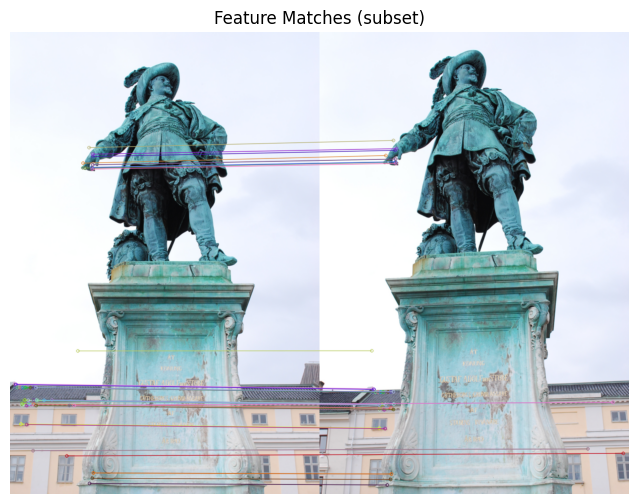

REPROJECTION ERROR:  0.003916996909693876


In [8]:

image_0 = img_obj.downscale_image(cv2.imread(img_obj.image_list[0]))
image_1 = img_obj.downscale_image(cv2.imread(img_obj.image_list[1]))

feature_0, feature_1 = find_features(image_0, image_1)

# Create fake keypoints just for visualization
kp0 = [cv2.KeyPoint(f[0], f[1], 1) for f in feature_0[:50]]
kp1 = [cv2.KeyPoint(f[0], f[1], 1) for f in feature_1[:50]]

matches = [cv2.DMatch(i, i, 0) for i in range(len(kp0))]

match_img = cv2.drawMatches(
    image_0, kp0,
    image_1, kp1,
    matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(15, 6))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title("Feature Matches (subset)")
plt.axis("off")
plt.show()


# Essential matrix
essential_matrix, em_mask = cv2.findEssentialMat(feature_0, feature_1, img_obj.K, method=cv2.RANSAC, prob=0.999, threshold=0.4, mask=None)
feature_0 = feature_0[em_mask.ravel() == 1]
feature_1 = feature_1[em_mask.ravel() == 1]

_, rot_matrix, tran_matrix, em_mask = cv2.recoverPose(essential_matrix, feature_0, feature_1, img_obj.K)
feature_0 = feature_0[em_mask.ravel() > 0]
feature_1 = feature_1[em_mask.ravel() > 0]
transform_matrix_1[:3, :3] = np.matmul(rot_matrix, transform_matrix_0[:3, :3])
transform_matrix_1[:3, 3] = transform_matrix_0[:3, 3] + np.matmul(transform_matrix_0[:3, :3], tran_matrix.ravel())

pose_1 = np.matmul(img_obj.K, transform_matrix_1)

feature_0, feature_1, points_3d = triangulation(pose_0, pose_1, feature_0, feature_1)
error, points_3d = reprojection_error(points_3d, feature_1, transform_matrix_1, img_obj.K, homogenity=1)
# ideally error < 1
print("REPROJECTION ERROR: ", error)
_, _, feature_1, points_3d, _ = PnP(points_3d, feature_1, img_obj.K, np.zeros((5, 1), dtype=np.float32), feature_0, initial=1)

total_images = len(img_obj.image_list) - 2
pose_array = np.hstack((np.hstack((pose_array, pose_0.ravel())), pose_1.ravel()))

threshold = 0.5


## **Incremental Reconstruction**

Each new image is added incrementally:
- 3D points are tracked across views
- Camera pose is estimated using PnP
- New points are triangulated
- Reprojection error validates reconstruction quality

This process continues until all images are processed.


In [9]:
for i in tqdm(range(total_images)):
    image_2 = img_obj.downscale_image(cv2.imread(img_obj.image_list[i + 2]))
    features_cur, features_2 = find_features(image_1, image_2)

    if i != 0:
        feature_0, feature_1, points_3d = triangulation(pose_0, pose_1, feature_0, feature_1)
        feature_1 = feature_1.T
        points_3d = cv2.convertPointsFromHomogeneous(points_3d.T)
        points_3d = points_3d[:, 0, :]

    cm_points_0, cm_points_1, cm_mask_0, cm_mask_1 = common_points(feature_1, features_cur, features_2)
    cm_points_2 = features_2[cm_points_1]
    cm_points_cur = features_cur[cm_points_1]

    rot_matrix, tran_matrix, cm_points_2, points_3d, cm_points_cur = PnP(points_3d[cm_points_0], cm_points_2, img_obj.K, np.zeros((5, 1), dtype=np.float32), cm_points_cur, initial=0)
    transform_matrix_1 = np.hstack((rot_matrix, tran_matrix))
    pose_2 = np.matmul(img_obj.K, transform_matrix_1)

    error, points_3d = reprojection_error(points_3d, cm_points_2, transform_matrix_1, img_obj.K, homogenity=0)

    cm_mask_0, cm_mask_1, points_3d = triangulation(pose_1, pose_2, cm_mask_0, cm_mask_1)
    error, points_3d = reprojection_error(points_3d, cm_mask_1, transform_matrix_1, img_obj.K, homogenity=1)
    print("Reprojection Error: ", error)


    pose_array = np.hstack((pose_array, pose_2.ravel()))

    total_points = np.vstack((total_points, points_3d[:, 0, :]))
    points_left = np.array(cm_mask_1, dtype=np.int32)
    color_vector = np.array([image_2[l[1], l[0]] for l in points_left.T])
    total_colors = np.vstack((total_colors, color_vector))

    transform_matrix_0 = np.copy(transform_matrix_1)
    pose_0 = np.copy(pose_1)

    image_0 = np.copy(image_1)
    image_1 = np.copy(image_2)
    feature_0 = np.copy(features_cur)
    feature_1 = np.copy(features_2)
    pose_1 = np.copy(pose_2)

print("Printing to .ply file")
print(total_points.shape, total_colors.shape)
to_ply(img_obj.path, total_points, total_colors)
print("Completed Exiting ...")

  2%|▏         | 1/55 [00:01<01:46,  1.98s/it]

 Shape New Array (558, 2) (558, 2)
Reprojection Error:  0.17232925556229237


  4%|▎         | 2/55 [00:05<02:26,  2.76s/it]

 Shape New Array (310, 2) (310, 2)
Reprojection Error:  1.5007955100175312


  5%|▌         | 3/55 [00:07<02:02,  2.36s/it]

 Shape New Array (363, 2) (363, 2)
Reprojection Error:  10.040333630236207


  7%|▋         | 4/55 [00:08<01:45,  2.06s/it]

 Shape New Array (381, 2) (381, 2)
Reprojection Error:  1.7976104793940357


  9%|▉         | 5/55 [00:10<01:36,  1.93s/it]

 Shape New Array (600, 2) (600, 2)
Reprojection Error:  0.8664183481827505


 11%|█         | 6/55 [00:12<01:29,  1.83s/it]

 Shape New Array (219, 2) (219, 2)
Reprojection Error:  10.822911888535492


 13%|█▎        | 7/55 [00:13<01:16,  1.59s/it]

 Shape New Array (498, 2) (498, 2)
Reprojection Error:  1.5473775575942712


 15%|█▍        | 8/55 [00:14<01:08,  1.47s/it]

 Shape New Array (239, 2) (239, 2)
Reprojection Error:  6.474502324647334


 16%|█▋        | 9/55 [00:16<01:13,  1.60s/it]

 Shape New Array (339, 2) (339, 2)
Reprojection Error:  0.3291671331934486


 18%|█▊        | 10/55 [00:18<01:18,  1.74s/it]

 Shape New Array (280, 2) (280, 2)
Reprojection Error:  3.712912391636985


 20%|██        | 11/55 [00:20<01:24,  1.91s/it]

 Shape New Array (316, 2) (316, 2)
Reprojection Error:  3.9514341645492435


 22%|██▏       | 12/55 [00:22<01:21,  1.89s/it]

 Shape New Array (246, 2) (246, 2)
Reprojection Error:  4.620269539779561


 24%|██▎       | 13/55 [00:23<01:14,  1.76s/it]

 Shape New Array (285, 2) (285, 2)
Reprojection Error:  2.856070557322197


 25%|██▌       | 14/55 [00:24<00:59,  1.45s/it]

 Shape New Array (330, 2) (330, 2)
Reprojection Error:  12.288312091738588


 27%|██▋       | 15/55 [00:25<00:48,  1.21s/it]

 Shape New Array (377, 2) (377, 2)
Reprojection Error:  2.600061805024378


 29%|██▉       | 16/55 [00:26<00:41,  1.07s/it]

 Shape New Array (412, 2) (412, 2)
Reprojection Error:  6.560272276256691


 31%|███       | 17/55 [00:26<00:36,  1.05it/s]

 Shape New Array (247, 2) (247, 2)
Reprojection Error:  5.761329856987493


 33%|███▎      | 18/55 [00:27<00:32,  1.15it/s]

 Shape New Array (404, 2) (404, 2)
Reprojection Error:  3.8017534465722105


 35%|███▍      | 19/55 [00:28<00:29,  1.22it/s]

 Shape New Array (460, 2) (460, 2)
Reprojection Error:  4.318103672727604


 36%|███▋      | 20/55 [00:28<00:27,  1.27it/s]

 Shape New Array (244, 2) (244, 2)
Reprojection Error:  6.292497645145557


 38%|███▊      | 21/55 [00:29<00:25,  1.34it/s]

 Shape New Array (458, 2) (458, 2)
Reprojection Error:  2.221409435853813


 40%|████      | 22/55 [00:30<00:23,  1.39it/s]

 Shape New Array (266, 2) (266, 2)
Reprojection Error:  5.721812430241433


 42%|████▏     | 23/55 [00:30<00:22,  1.41it/s]

 Shape New Array (419, 2) (419, 2)
Reprojection Error:  5.694494980219736


 44%|████▎     | 24/55 [00:31<00:21,  1.43it/s]

 Shape New Array (338, 2) (338, 2)
Reprojection Error:  19.060711742217684


 45%|████▌     | 25/55 [00:32<00:23,  1.27it/s]

 Shape New Array (401, 2) (401, 2)
Reprojection Error:  13.895241012637392


 47%|████▋     | 26/55 [00:33<00:25,  1.14it/s]

 Shape New Array (332, 2) (332, 2)
Reprojection Error:  155.41952380039925


 49%|████▉     | 27/55 [00:34<00:26,  1.05it/s]

 Shape New Array (368, 2) (368, 2)
Reprojection Error:  3.9197937015836324


 51%|█████     | 28/55 [00:35<00:26,  1.00it/s]

 Shape New Array (469, 2) (469, 2)
Reprojection Error:  7.214861916484703


 53%|█████▎    | 29/55 [00:36<00:24,  1.06it/s]

 Shape New Array (285, 2) (285, 2)
Reprojection Error:  17.35384830004888


 55%|█████▍    | 30/55 [00:37<00:21,  1.15it/s]

 Shape New Array (395, 2) (395, 2)
Reprojection Error:  1.655135982668791


 56%|█████▋    | 31/55 [00:38<00:19,  1.25it/s]

 Shape New Array (338, 2) (338, 2)
Reprojection Error:  21.430111931322326


 58%|█████▊    | 32/55 [00:38<00:17,  1.31it/s]

 Shape New Array (313, 2) (313, 2)
Reprojection Error:  0.06923706843826273


 60%|██████    | 33/55 [00:39<00:16,  1.37it/s]

 Shape New Array (312, 2) (312, 2)
Reprojection Error:  4.574849073407274


 62%|██████▏   | 34/55 [00:40<00:15,  1.39it/s]

 Shape New Array (500, 2) (500, 2)
Reprojection Error:  2.92997448277361


 64%|██████▎   | 35/55 [00:40<00:14,  1.40it/s]

 Shape New Array (181, 2) (181, 2)
Reprojection Error:  4.8555691061398125


 65%|██████▌   | 36/55 [00:41<00:13,  1.45it/s]

 Shape New Array (330, 2) (330, 2)
Reprojection Error:  0.2925162938408716


 67%|██████▋   | 37/55 [00:41<00:12,  1.49it/s]

 Shape New Array (291, 2) (291, 2)
Reprojection Error:  0.8165913471278448


 69%|██████▉   | 38/55 [00:42<00:11,  1.48it/s]

 Shape New Array (285, 2) (285, 2)
Reprojection Error:  2.0649847761708737


 71%|███████   | 39/55 [00:43<00:10,  1.48it/s]

 Shape New Array (448, 2) (448, 2)
Reprojection Error:  2.698651568693882


 73%|███████▎  | 40/55 [00:44<00:10,  1.47it/s]

 Shape New Array (253, 2) (253, 2)
Reprojection Error:  1.4376564430264551


 75%|███████▍  | 41/55 [00:44<00:09,  1.47it/s]

 Shape New Array (324, 2) (324, 2)
Reprojection Error:  2.996578011391603


 76%|███████▋  | 42/55 [00:45<00:08,  1.47it/s]

 Shape New Array (370, 2) (370, 2)
Reprojection Error:  1.3870315925151229


 78%|███████▊  | 43/55 [00:46<00:08,  1.43it/s]

 Shape New Array (315, 2) (315, 2)
Reprojection Error:  32.01482097570734


 80%|████████  | 44/55 [00:47<00:09,  1.17it/s]

 Shape New Array (366, 2) (366, 2)
Reprojection Error:  10.366641730473523


 82%|████████▏ | 45/55 [00:48<00:09,  1.05it/s]

 Shape New Array (345, 2) (345, 2)
Reprojection Error:  2.1159980635711824


 84%|████████▎ | 46/55 [00:49<00:09,  1.03s/it]

 Shape New Array (426, 2) (426, 2)
Reprojection Error:  0.24235396320520394


 85%|████████▌ | 47/55 [00:51<00:09,  1.24s/it]

 Shape New Array (495, 2) (495, 2)
Reprojection Error:  1.7556002899244796


 87%|████████▋ | 48/55 [00:52<00:09,  1.32s/it]

 Shape New Array (630, 2) (630, 2)
Reprojection Error:  1.9137430926503392


 89%|████████▉ | 49/55 [00:54<00:08,  1.39s/it]

 Shape New Array (306, 2) (306, 2)
Reprojection Error:  4.794273943527111


 91%|█████████ | 50/55 [00:55<00:06,  1.24s/it]

 Shape New Array (502, 2) (502, 2)
Reprojection Error:  0.9075385566341927


 93%|█████████▎| 51/55 [00:56<00:04,  1.12s/it]

 Shape New Array (503, 2) (503, 2)
Reprojection Error:  1.6221374959924426


 95%|█████████▍| 52/55 [00:57<00:03,  1.05s/it]

 Shape New Array (475, 2) (475, 2)
Reprojection Error:  1.312382362040148


 96%|█████████▋| 53/55 [00:57<00:01,  1.01it/s]

 Shape New Array (448, 2) (448, 2)
Reprojection Error:  0.8800087327142692


 98%|█████████▊| 54/55 [00:58<00:00,  1.04it/s]

 Shape New Array (433, 2) (433, 2)
Reprojection Error:  0.3679952362531567


100%|██████████| 55/55 [00:59<00:00,  1.09s/it]

 Shape New Array (460, 2) (460, 2)
Reprojection Error:  0.34061467909435766
Printing to .ply file
(20489, 3) (20489, 3)
Completed Exiting ...
